# Installing all the required tools:
Any missing tool(s) can be installed by using pip command. 


In [ ]:
#!pip install pycaret
#!pip install numpy
#!pip install pandas matplotlib seaborn sklearn

# 2. Getting the Tools Ready:

In [21]:
import pandas as pd
import sys
import numpy as np
import pickle
from pycaret.classification import * 
import seaborn as sns
import matplotlib.pyplot as plt

from final_project.tester import dump_classifier_and_data
from tools.feature_format import featureFormat, targetFeatureSplit


# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from final_project.tester import test_classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# 3. Loading the data:

In [22]:
### Load the dictionary containing the dataset
with open("/content/final_project/final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# 4. Getting the data Ready:

In the intial run we will take all the available features and then based on analysis report we will select the best ones. 

In [23]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'deferred_income',
                 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',
                 'to_messages', 'from_poi_to_this_person', 'from_messages',
                 'from_this_person_to_poi', 'shared_receipt_with_poi'] 

In [48]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)

### converting the data to df for some analysis and exploration
my_data = pd.DataFrame(data, columns=features_list)
my_data.head()

,poi,salary,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
0,0.0,201955.0,2869717.0,4484442.0,0.0,4175000.0,-126027.0,-3081055.0,1729541.0,13868.0,1729541.0,152.0,304805.0,126027.0,0.0,2902.0,47.0,2195.0,65.0,1407.0
1,0.0,0.0,178980.0,182466.0,0.0,0.0,0.0,0.0,257817.0,3486.0,257817.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,477.0,0.0,916197.0,0.0,0.0,-560222.0,-5104.0,5243487.0,56301.0,4046157.0,864523.0,0.0,1757552.0,0.0,566.0,39.0,29.0,0.0,465.0
3,0.0,267102.0,1295738.0,5634343.0,0.0,1200000.0,0.0,-1386055.0,10623258.0,11200.0,6680544.0,2660303.0,1586055.0,3942714.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,239671.0,260455.0,827696.0,0.0,400000.0,-82782.0,-201641.0,63014.0,129142.0,0.0,69.0,0.0,145796.0,0.0,0.0,0.0,0.0,0.0,0.0


### i. Exploratory Data Analysis

In [26]:
# inspect info
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   poi                        145 non-null    float64
 1   salary                     145 non-null    float64
 2   deferral_payments          145 non-null    float64
 3   total_payments             145 non-null    float64
 4   loan_advances              145 non-null    float64
 5   bonus                      145 non-null    float64
 6   restricted_stock_deferred  145 non-null    float64
 7   deferred_income            145 non-null    float64
 8   total_stock_value          145 non-null    float64
 9   expenses                   145 non-null    float64
 10  exercised_stock_options    145 non-null    float64
 11  other                      145 non-null    float64
 12  long_term_incentive        145 non-null    float64
 13  restricted_stock           145 non-null    float64

**We see no missing values because they were imputed with '0'. But it doesnt mean that there is no missing values. We will find their % later.**

#### (A). Total Number of data points and their distribution across different classes (poi/non-poi)

In [27]:
### how many data points we have?
len(my_data)

145

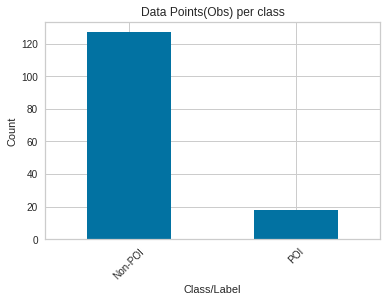

In [33]:
### distribution across different classes
plt.title('Data Points(Obs) per class')
plt.xlabel('Class/Label')
plt.ylabel('Count')
my_data['poi'].value_counts().plot.bar()
plt.xticks([0, 1], labels=['Non-POI', 'POI'], rotation=45)
plt.show()

#### (B). Looking up for the missing values in availble features and filtereing the ones with less than 50% missing values. 

In [51]:
### find how many values are missing in each column
filtered_features_missing = []
missing_count = []
for col in features_list[1:]:
  missing_vals = len(my_data[col][np.where(my_data[col]==0)[0]])
  missing_count.append(missing_vals)
  total_vals = len(my_data[col])
  ptc_missing = missing_vals / total_vals
  if ptc_missing < 0.5:
    filtered_features_missing.append(col)
  print(f'{col} = {ptc_missing:.2f}%')

salary = 0.34%
deferral_payments = 0.73%
total_payments = 0.14%
loan_advances = 0.97%
bonus = 0.43%
restricted_stock_deferred = 0.88%
deferred_income = 0.66%
total_stock_value = 0.13%
expenses = 0.34%
exercised_stock_options = 0.30%
other = 0.36%
long_term_incentive = 0.54%
restricted_stock = 0.24%
director_fees = 0.88%
to_messages = 0.41%
from_poi_to_this_person = 0.49%
from_messages = 0.41%
from_this_person_to_poi = 0.54%
shared_receipt_with_poi = 0.41%


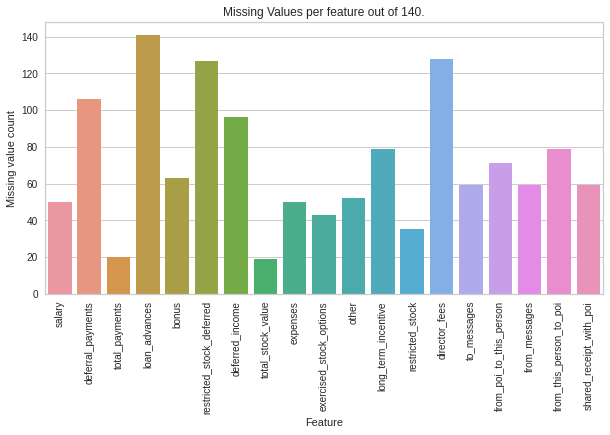

In [43]:
### Visualizing the missing values (by count)
plt.figure(figsize=(10,5))
sns.barplot(x=features_list[1:], y=missing_count)
plt.xticks(rotation=90)
plt.title('Missing Values per feature out of 140.')
plt.xlabel('Feature')
plt.ylabel('Missing value count')
plt.show()

In [68]:
### some filtered features those are having less than 50% missing values
filtered_features_missing

['poi',
 'salary',
 'total_payments',
 'bonus',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'restricted_stock',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'shared_receipt_with_poi']

#### (C). Finding the correlation between dependent and independant variable

In [67]:
my_data.corr().iloc[0]

poi                          1.000000
salary                      -0.001058
deferral_payments           -0.040847
total_payments               0.049386
loan_advances                0.131550
bonus                        0.023341
restricted_stock_deferred   -0.005402
deferred_income             -0.039149
total_stock_value            0.034064
expenses                    -0.009886
exercised_stock_options      0.039922
other                        0.021832
long_term_incentive          0.012467
restricted_stock             0.014801
director_fees               -0.061847
to_messages                  0.110006
from_poi_to_this_person      0.191549
from_messages               -0.033302
from_this_person_to_poi      0.130319
shared_receipt_with_poi      0.242105
Name: poi, dtype: float64

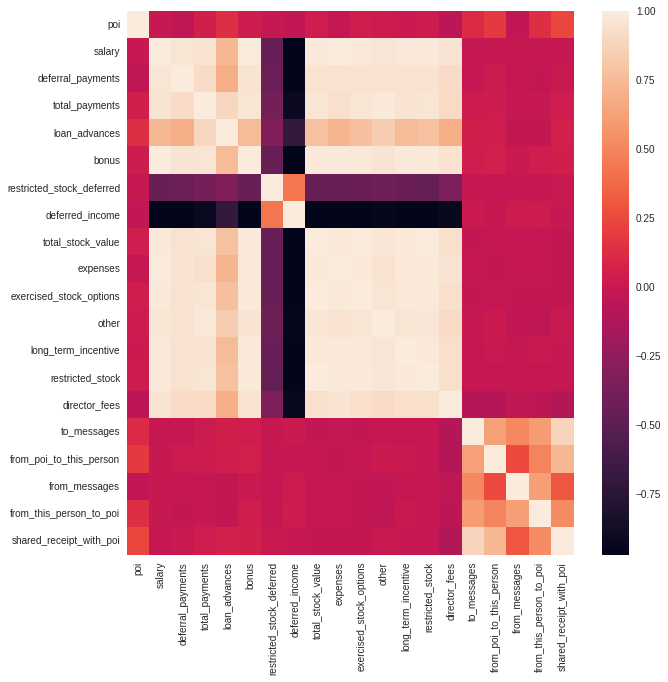

In [47]:
### find the correlation in all_features
plt.figure(figsize=(10, 10))
sns.heatmap(my_data.corr());

**There is no super corelation.**

#### (D). Is the Data Balanced?

In [ ]:
pd.DataFrame(data_dict).T['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

**Data is very much imbalanced and more biased to class 0.**

### ii. Data Preparation
We will prepare the data for better analysis and modeling. We will
1. Select higly correlated features
2. Create new feature(s)
3. Remove the outliers

#### 1. Select higly correlated features

In [66]:
### selecting only highly correlated featues
highly_corr_feats = []
for label, value in my_data.corr().iloc[0, 1:].items():
  if abs(value) >= 0.1:
    print(label, value)
    highly_corr_feats.append(label)

highly_corr_feats.insert(0, 'poi')
highly_corr_feats

loan_advances 0.13155023418667247
to_messages 0.11000624180535844
from_poi_to_this_person 0.19154947816078596
from_this_person_to_poi 0.13031871741439627
shared_receipt_with_poi 0.24210506423283196


['poi',
 'loan_advances',
 'to_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi']

In [69]:
### Extract features and labels from dataset for local testing
data_selected = featureFormat(my_dataset, highly_corr_feats, sort_keys = True)

### converting the data to df for some analysis and exploration
my_data_selected = pd.DataFrame(data_selected, columns=highly_corr_feats)
my_data_selected.head()

,poi,loan_advances,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
0,0.0,0.0,2902.0,47.0,65.0,1407.0
1,0.0,0.0,566.0,39.0,0.0,465.0
2,0.0,0.0,7315.0,144.0,386.0,2639.0
3,1.0,0.0,7991.0,228.0,108.0,5521.0
4,0.0,0.0,383.0,4.0,0.0,233.0


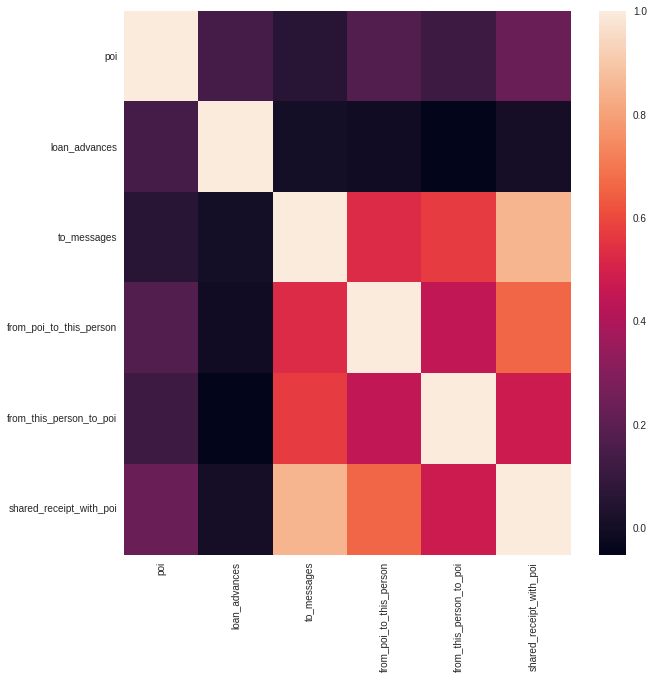

In [70]:
## corelation in filtered features
plt.figure(figsize=(10, 10))
sns.heatmap(my_data_selected.corr());

In [13]:
### Task 2: Remove outliers
### Task 3: Create new feature(s)

In [ ]:
### creating a new feature
my_data['pct_amount_paid_from_bonus'] = my_data['bonus']/ my_data['total_payments']
my_data.fillna(0, inplace=True)

### modeling experiments
1. Take all the data as it is and find the baseline model.

In [18]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

In [ ]:
experiment = setup(my_data, target='poi')  
best_model = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8418,0.7771,0.35,0.2917,0.3133,0.2520,0.2532,0.096
nb,Naive Bayes,0.4245,0.6125,0.80,0.1731,0.2718,0.0696,0.1189,0.017
lightgbm,Light Gradient Boosting Machine,0.8518,0.7979,0.30,0.2500,0.2667,0.2154,0.2167,0.067
gbc,Gradient Boosting Classifier,0.8327,0.7299,0.20,0.2500,0.2167,0.1426,0.1454,0.155
lr,Logistic Regression,0.8218,0.6243,0.20,0.2000,0.1833,0.1035,0.1140,0.429
dt,Decision Tree Classifier,0.7636,0.5438,0.25,0.1583,0.1833,0.0543,0.0639,0.016
ridge,Ridge Classifier,0.8436,0.0000,0.15,0.2250,0.1667,0.1086,0.1189,0.016
lda,Linear Discriminant Analysis,0.8336,0.6722,0.15,0.2250,0.1667,0.1043,0.1134,0.018
qda,Quadratic Discriminant Analysis,0.7918,0.6799,0.05,0.0500,0.0500,-0.0109,-0.0217,0.017
et,Extra Trees Classifier,0.8218,0.7229,0.05,0.0500,0.0500,-0.0052,-0.0063,0.465


In [ ]:
best_model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8895)

#### best model found in first experiment
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8895)

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

In [15]:
scaller = MinMaxScaler()

best_model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8895)

#### model training and evaluation

In [16]:
### testing the best model with tester code
### splitting the selected data into X(features-independent vars) and y (labels-dependent vars)
labels, features = targetFeatureSplit(my_data.values)

### ### scalling the data
features_scalled  = scaller.fit_transform(features)


### split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(features_scalled, labels, test_size=0.2, random_state=42)

In [17]:
### train the model 
best_model.fit(X_train, y_train)

AdaBoostClassifier(random_state=8895)

In [18]:
### evaluate the model on testing data
### accuracy
preds = best_model.predict(X_test)

acc = best_model.score(X_test, y_test)
print('Accuracy=', acc)

prec = precision_score(y_test, preds)
print('Precision=', prec)

recall = recall_score(y_test, preds)
print('Recall=', recall)


Accuracy= 0.8620689655172413
Precision= 0.5
Recall= 0.5


In [19]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

precision, recall, accuracy = test_classifier(best_model, my_dataset, features_list, folds=200)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print()

Precision: 0.3824451410658307
Recall: 0.305
Accuracy: 0.8416666666666667



In [20]:
#### saving the classifier
dump_classifier_and_data(best_model, my_dataset, features_list)